In [18]:
# Always run this - needed for later data processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# # Laser wavelength settings: Set parameters for wavelength sweep
WAV_START = 1535
WAV_END = 1540
speed = 2                    # Sweep speed (units of nm/s)
step_size = "10pm"             # step size of sweep. Read TSL manual pg 42/113 for minimum step size based on speed
delay_between_sweeps = 0.5
set_laser_power = 10            # Setting the laser power in dBm

print("Laser settings configured") 

Laser settings configured


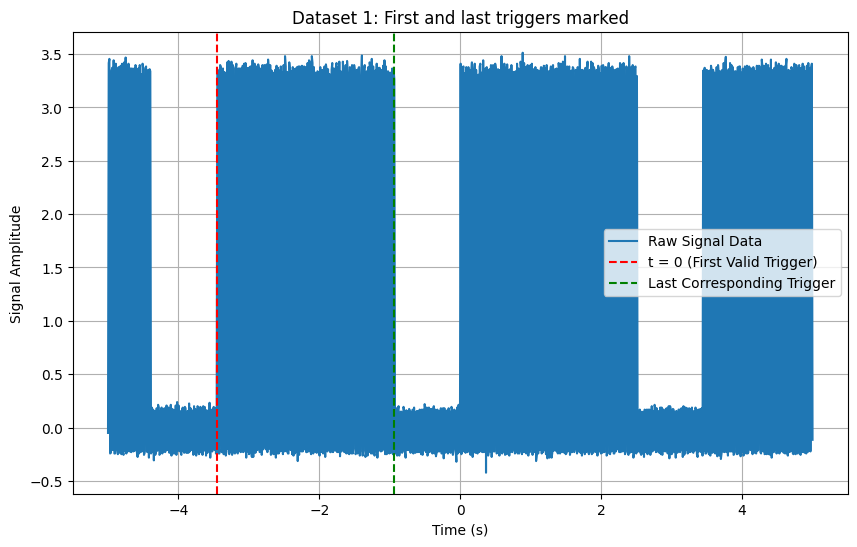

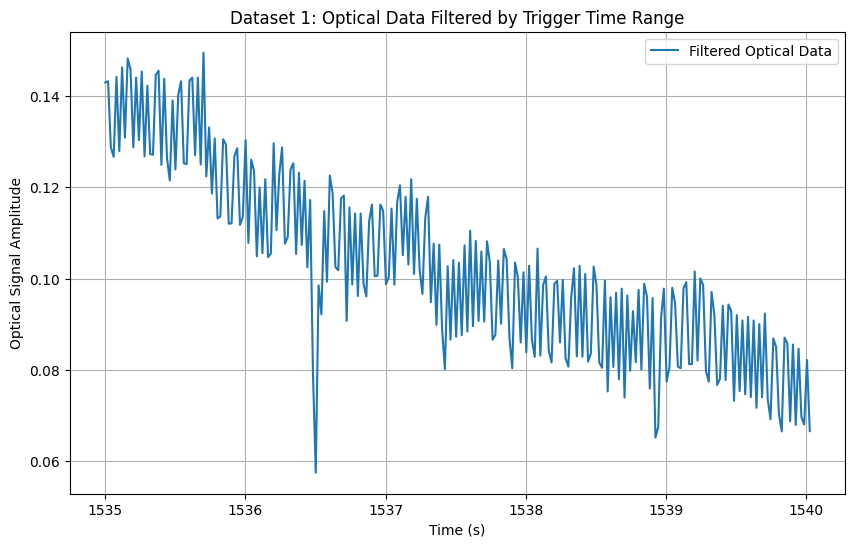

Dataset 1 processed and interpolated.


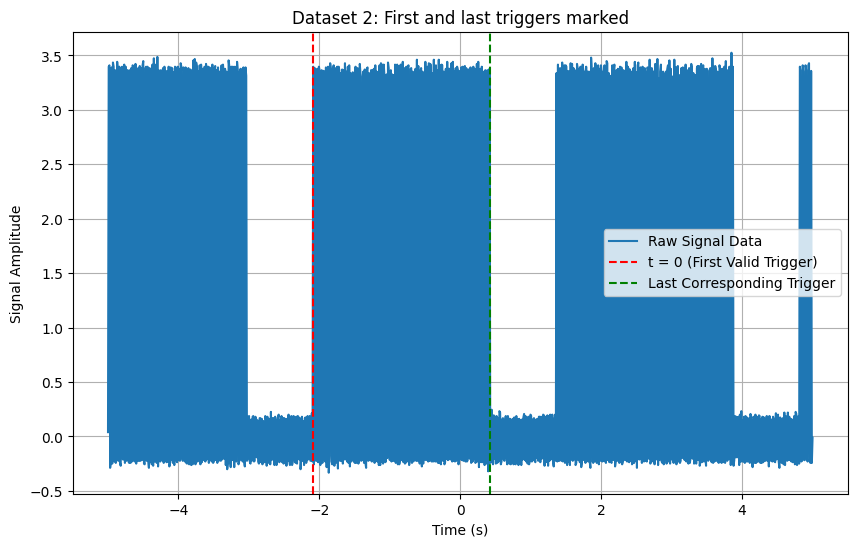

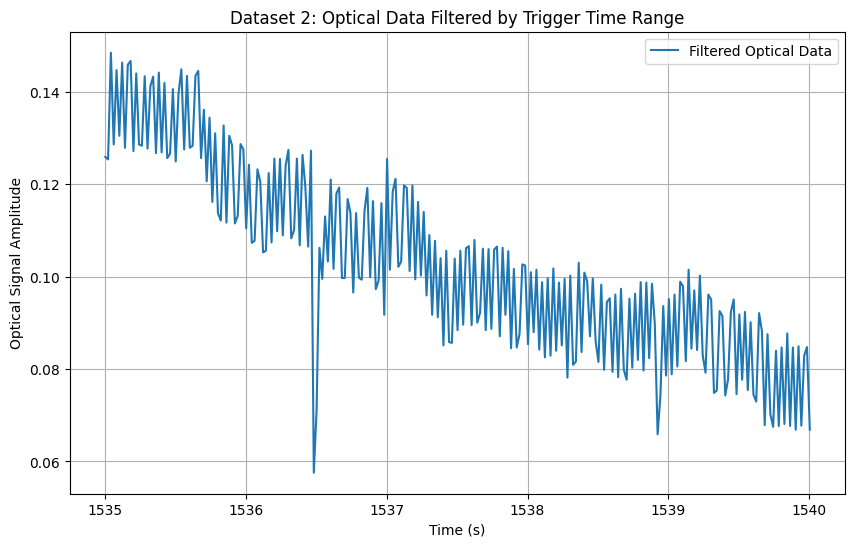

Dataset 2 processed and interpolated.


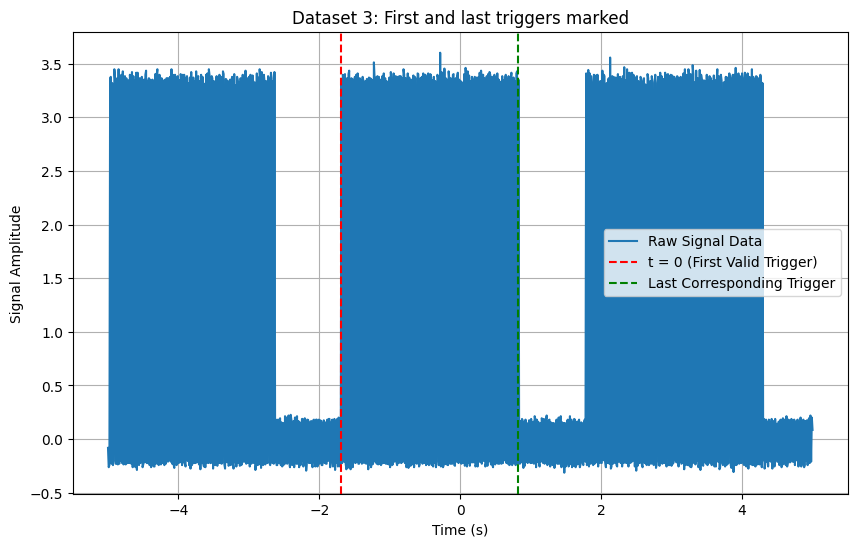

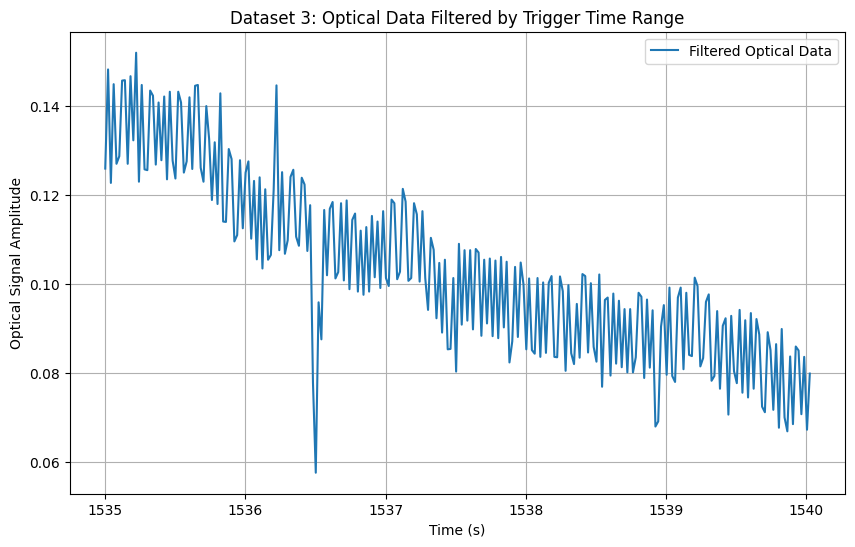

Dataset 3 processed and interpolated.


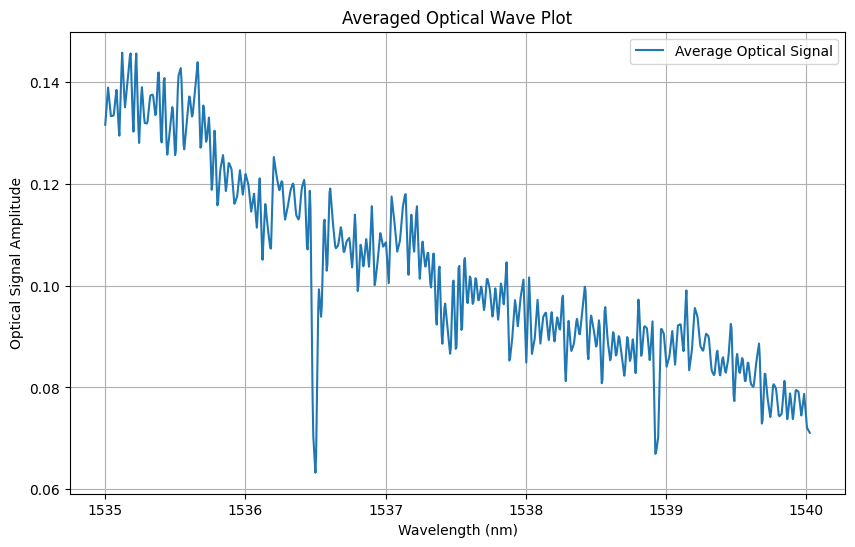

In [ ]:
# # Data collection of optical absorption

threshold = 1       # Voltage threshold for triggering
quiet_period_duration = 0.3  # Seconds of quiet period before checking
# WAV_START = 1535  # nm, already indicated beforehand
# speed = 1  # nm/s, already indicated beforehand

def load_data(file_path):
    """Load data from a CSV file."""
    data = pd.read_csv(file_path)
    time_data = data.iloc[:, 0].values
    signal_data = data.iloc[:, 1].values
    return time_data, signal_data


def find_first_trigger(time_data, signal_data, threshold=threshold, quiet_period_duration=quiet_period_duration):
    """Find the first valid trigger based on the threshold and quiet period."""
    # Identify indices where the signal exceeds the threshold
    trigger_indices = np.where(signal_data > threshold)[0]
    # print(f"Trigger indices (signal > {threshold}): {trigger_indices}")
    
    for i in range(len(trigger_indices) - 1):
        if time_data[trigger_indices[i+1]] - time_data[trigger_indices[i]] >= quiet_period_duration:
            return trigger_indices, trigger_indices[i+1], time_data[trigger_indices[i+1]]

    raise ValueError("No valid trigger found")


def find_last_trigger(time_data, trigger_indices, valid_trigger_index, quiet_period_duration=quiet_period_duration):
    """Find the last valid trigger within the same sweep as the first valid trigger. """

    # Filter triggers to only those occurring after the first valid trigger (t=0)
    post_t0_trigger_indices = trigger_indices[trigger_indices >= valid_trigger_index]
    # print(f"Post t=0 trigger indices: {post_t0_trigger_indices}")

    for i in range(len(post_t0_trigger_indices) - 1):
        # Check if the time difference satisfies the quiet period condition
        if time_data[post_t0_trigger_indices[i + 1]] - time_data[post_t0_trigger_indices[i]] >= quiet_period_duration:
            # print(f"Last valid trigger found at index {post_t0_trigger_indices[i]} with time {time_data[post_t0_trigger_indices[i]]}s.")
            return post_t0_trigger_indices[i], time_data[post_t0_trigger_indices[i]]

    # If no valid last trigger is found, the last trigger in the dataset is valid
    last_trigger_index = post_t0_trigger_indices[-1]
    print(f"Defaulting to the last trigger in the dataset at index {last_trigger_index} with time {time_data[last_trigger_index]}s.")
    return last_trigger_index, time_data[last_trigger_index]


############################################################### END OF FUNCTION DEFINITION ##############################################################

# Some test data to run this code
triggercsvfilenames = [r'C:\Users\groov\VSCode\CSV_Waveforms\18.11.2024_14.03.42_triggers_ch1.csv',
                       r'C:\Users\groov\VSCode\CSV_Waveforms\18.11.2024_14.03.30_triggers_ch1.csv',
                       r'C:\Users\groov\VSCode\CSV_Waveforms\18.11.2024_14.03.19_triggers_ch1.csv']
opticalcsvfilenames = [r'C:\Users\groov\VSCode\CSV_Waveforms\18.11.2024_14.03.42_optical_ch2.csv',
                       r'C:\Users\groov\VSCode\CSV_Waveforms\18.11.2024_14.03.30_optical_ch2.csv',
                       r'C:\Users\groov\VSCode\CSV_Waveforms\18.11.2024_14.03.19_optical_ch2.csv']

# Store interpolated signals for averaging
common_wavelength = None
interpolated_signals = []

# Confirmation of t=0 times (first triggers) and corresponding last triggers
for idx, (trigger_file, optical_file) in enumerate(zip(triggercsvfilenames, opticalcsvfilenames)):

    # Load trigger data
    trigger_time, trigger_signal = load_data(trigger_file)

    # Find the first valid trigger and mark t=0
    trigger_indices, valid_trigger_index, t0_reference = find_first_trigger(time_data=trigger_time, signal_data=trigger_signal)

    last_valid_trigger_index, t_end_time = find_last_trigger(time_data=trigger_time, trigger_indices=trigger_indices, valid_trigger_index=valid_trigger_index)

    # Plot the raw signal with t=0 marked
    plt.figure(figsize=(10, 6))
    plt.plot(trigger_time, trigger_signal, label="Raw Signal Data")
    plt.axvline(x=t0_reference, color='r', linestyle='--', label="t = 0 (First Valid Trigger)")
    plt.axvline(x=t_end_time, color='g', linestyle='--', label="Last Corresponding Trigger")
    plt.xlabel("Time (s)")
    plt.ylabel("Signal Amplitude")
    plt.title(f"Dataset {idx + 1}: First and last triggers marked")
    plt.legend()
    plt.grid()
    plt.show()

    # Load optical data
    optical_time, optical_signal = load_data(optical_file)

    # Align optical data to t=0 from trigger data
    adjusted_optical_time = optical_time - t0_reference

    # Filter optical data to include only times between t=0 and t=end
    valid_optical_indices = (adjusted_optical_time >= 0) & (adjusted_optical_time <= (t_end_time - t0_reference))

    filtered_optical_time = adjusted_optical_time[valid_optical_indices]
    # Convert filtered optical time to wavelength

    filtered_optical_signal = optical_signal[valid_optical_indices]

    filtered_wavelength = WAV_START + speed * filtered_optical_time

    # Pre-averaging wavelength code
    # Plot the filtered optical data
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_wavelength, filtered_optical_signal, label="Filtered Optical Data")
    plt.xlabel("Time (s)")
    plt.ylabel("Optical Signal Amplitude")
    plt.title(f"Dataset {idx + 1}: Optical Data Filtered by Trigger Time Range")
    plt.legend()
    plt.grid()
    plt.show()

    # Create a common wavelength axis if not already created
    if common_wavelength is None:
        common_wavelength = np.linspace(
            min(filtered_wavelength), max(filtered_wavelength), 1000
        )  # 1000 points for interpolation

    # Interpolate the signal to the common wavelength axis
    interpolated_signal = np.interp(common_wavelength, filtered_wavelength, filtered_optical_signal)
    interpolated_signals.append(interpolated_signal)

    print(f"Dataset {idx + 1} processed and interpolated.")

    # Compute the average signal
interpolated_signals = np.array(interpolated_signals)  # Convert to NumPy array
average_signal = np.mean(interpolated_signals, axis=0)

# Plot the averaged optical wave plot
plt.figure(figsize=(10, 6))
plt.plot(common_wavelength, average_signal, label="Average Optical Signal")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Optical Signal Amplitude")
plt.title("Averaged Optical Wave Plot")
plt.legend()
plt.grid()
plt.show()

